### 1. Install mmdetection

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

In [ ]:
# Install dependencies
%pip install -U openmim
!mim install "mmengine>=0.7.0"
!mim install "mmcv==2.1.0"

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git -b dev-3.x
%cd mmdetection
%pip install -v -e .

# Back to the root directory
%cd ..

In [ ]:
from mmengine.utils import get_git_hash
from mmengine.utils.dl_utils import collect_env as collect_base_env

import mmdet


def collect_env():
    """Collect the information of the running environments."""
    env_info = collect_base_env()
    env_info['MMDetection'] = f'{mmdet.__version__}+{get_git_hash()[:7]}'
    return env_info

if __name__ == '__main__':
    for name, val in collect_env().items():
        print(f'{name}: {val}')

### 2. Train the model

In [ ]:
!python tools/train.py configs/pascal_voc/faster-rcnn_r50_fpn_1x_voc0712.py      
!python tools/train.py configs/pascal_voc/yolov3.py      

### 3. Inference

#### 3.1 Generate the bounding box

In [2]:
import warnings
from mmdet.apis import DetInferencer
warnings.filterwarnings("ignore")

rcnn_inferencer = DetInferencer(
    model='./configs/pascal_voc/faster-rcnn_r50_fpn_1x_voc0712.py', 
    weights='./work_dirs/faster-rcnn_r50_fpn_1x_voc0712/faster_rcnn.pth',
    device='cpu'
)
rcnn_inferencer('./demo/faster_rcnn', out_dir='./outputs/faster_rcnn', no_save_pred=False)

Loads checkpoint by local backend from path: ./work_dirs/faster-rcnn_r50_fpn_1x_voc0712/faster_rcnn.pth


Output()

{'predictions': [{'labels': [14, 11, 14, 11, 8],
   'scores': [0.9958969354629517,
    0.9182937741279602,
    0.3312239646911621,
    0.13642971217632294,
    0.05360286310315132],
   'bboxes': [[16.854793548583984,
     0.6327012181282043,
     353.0,
     496.7027587890625],
    [57.88056945800781,
     237.27133178710938,
     193.06988525390625,
     356.6759948730469],
    [111.82536315917969, 9.266779899597168, 353.0, 284.8676452636719],
    [31.674373626708984, 167.51327514648438, 336.39453125, 472.81976318359375],
    [0.0, 120.09380340576172, 353.0, 500.0000305175781]]},
  {'labels': [6, 6, 6, 6, 6, 6],
   'scores': [0.9993211030960083,
    0.9983477592468262,
    0.9981716871261597,
    0.9876318573951721,
    0.9387967586517334,
    0.11434633284807205],
   'bboxes': [[13.622654914855957,
     308.8896179199219,
     85.55917358398438,
     363.7727355957031],
    [358.79962158203125,
     326.07073974609375,
     497.112060546875,
     389.7549743652344],
    [231.32275390

#### 3.2 Compare the bounding box

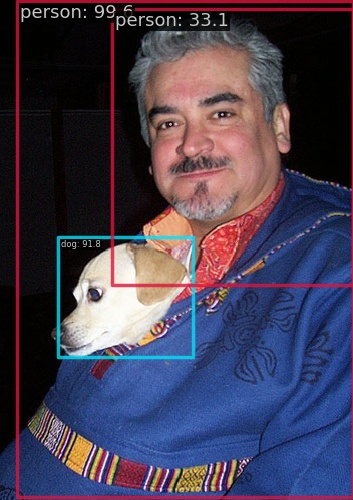

In [4]:
from PIL import Image

Image.open('./outputs/faster_rcnn/vis/000001.jpg')

Loads checkpoint by local backend from path: ./work_dirs/yolov3/yolov3.pth


Output()

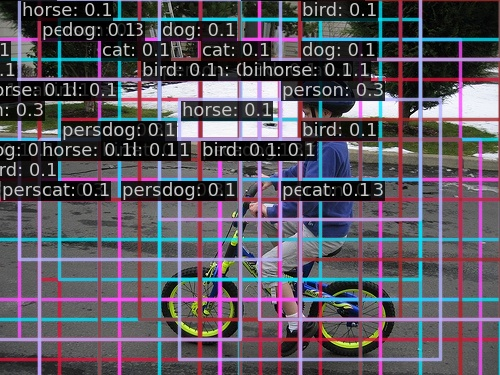

In [13]:
import warnings
from mmdet.apis import DetInferencer
warnings.filterwarnings("ignore")

rcnn_inferencer = DetInferencer(
    model='./configs/pascal_voc/yolov3.py', 
    weights='./work_dirs/yolov3/yolov3.pth',
    device='cpu'
)
rcnn_inferencer('./demo/yolov3', out_dir='./outputs/yolov3', no_save_pred=True, pred_score_thr=0.0005)

from PIL import Image

Image.open('./outputs/yolov3/vis/000230.jpg')

In [12]:
import torch
from mmdet.apis import init_detector, inference_detector
import mmcv
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Configuration file and checkpoint file
config_file = './configs/pascal_voc/faster-rcnn_r50_fpn_1x_voc0712.py'
checkpoint_file = './work_dirs/faster-rcnn_r50_fpn_1x_voc0712/faster_rcnn.pth'

# Load config and model
model = init_detector(config_file, checkpoint_file, device='cpu')  # loading the model

# Set the model to evaluation mode
model.eval()

print(model)

Loads checkpoint by local backend from path: ./work_dirs/faster-rcnn_r50_fpn_1x_voc0712/faster_rcnn.pth
FasterRCNN(
  (data_preprocessor): DetDataPreprocessor()
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm

In [10]:

def get_proposals(model, image_path):
    # Load and preprocess the image
    image = mmcv.imread(image_path)
    # Convert the image to a PyTorch tensor
    image_tensor = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0)  # (C, H, W) and add batch dimension
    data = dict(img=[image_tensor], img_metas=[[dict(img_shape=image.shape, ori_shape=image.shape, pad_shape=image.shape, scale_factor=1.0, flip=False)]])

    # Forward pass through the RPN
    with torch.no_grad():
        features = model.extract_feat(data['img'][0])
        proposal_list = model.rpn_head.simple_test_rpn(features, data['img_metas'][0])
    
    return proposal_list[0], image

# Path to a VOC image
image_path = './demo/000001.jpg'
proposals, image = get_proposals(model, image_path)

def visualize_proposals(image, proposals, num_proposals=100):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(mmcv.bgr2rgb(image))

    # Draw the top proposals
    for i in range(min(num_proposals, len(proposals))):
        x1, y1, x2, y2 = proposals[i]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Visualize the top 100 proposals
visualize_proposals(image, proposals)


<class 'dict'>
